In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as splt
from datetime import datetime
# Load the Drive helper and mount
from google.colab import drive
import zipfile

In [ ]:

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:

!ls drive/MyDrive/Capstone/Dataset

01_doc.txt	      03_plugs_csv.zip	    05_sm_csv.zip
01_occupancy_csv.zip  03_plugs_matlab.zip   05_sm_matlab.zip
01_plugs_csv.zip      03_sm_csv.zip	    06_doc.txt
01_plugs_matlab.zip   03_sm_matlab.zip	    06_plugs_csv.zip
01_sm_csv.zip	      04_doc.txt	    06_plugs_matlab.zip
01_sm_matlab.zip      04_occupancy_csv.zip  06_sm_csv.zip
02_doc.txt	      04_plugs_csv.zip	    06_sm_matlab.zip
02_occupancy_csv.zip  04_plugs_matlab.zip   cleaned_data
02_plugs_csv.zip      04_sm_csv.zip	    cleaned_data_1m
02_plugs_matlab.zip   04_sm_matlab.zip	    cleaned_data_1m.csv
02_sm_csv.zip	      05_doc.txt	    cleaned_data.csv
02_sm_matlab.zip      05_occupancy_csv.zip  READ_ME_FIRST.txt
03_doc.txt	      05_plugs_csv.zip
03_occupancy_csv.zip  05_plugs_matlab.zip


In [ ]:

def process_smfile(x,sample):
  col=['p_total','p_phase1','p_phase2','p_phase3','i_neutral','i_phase1','i_phase2','i_phase3','v_phase1','v_phase2','v_phase3','psbv12','psbv31','psbi1','psbi2','psbi3']
  zf = zipfile.ZipFile('drive/MyDrive/Capstone/Dataset/0%s_sm_csv.zip'%x)
  df=pd.DataFrame()
  tmp1=[i for i in zf.namelist() if ".csv" in i]
  for i in tmp1:
    tmp = pd.read_csv(zf.open(i),header=None,names=col)
    if x==4:
      tmp['Date']=pd.to_datetime(i.split('/')[2].split('.')[0])
    else:
      tmp['Date']=pd.to_datetime(i.split('/')[1].split('.')[0])
    tmp['Time']=pd.timedelta_range(start='0 day', end='1 days', freq='1s')[:-1]
    tmp['Datetime']=tmp.Date+tmp.Time
    tmp.index = tmp.Datetime
    tmp.drop(['Date','Time','Datetime'],axis=1,inplace=True)
    resampled=tmp.resample(sample).mean().round()
    df=pd.concat([df,resampled])
  return df


def process_ocfile(x,sample):
  zf = zipfile.ZipFile('drive/MyDrive/Capstone/Dataset/0%s_occupancy_csv.zip'%x)
  df = pd.concat(map(pd.read_csv,map(zf.open,zf.namelist())))
  df.rename(columns={'Unnamed: 0':'Date'},inplace=True)
  df.set_index('Date',inplace=True)
  df.columns=list(map(lambda x: x.replace("'",""),df.columns))
  df_t=df.T
  df_t.index = pd.to_timedelta(df_t.index)
  df_t.index.name='Time'
  resampled=df_t.resample(sample).mean().round()
  stk=resampled.stack()
  tmp=stk.reset_index()
  tmp.Date=pd.to_datetime(tmp.Date, format="%d-%b-%Y")
  tmp['Datetime']=tmp.Date+tmp.Time
  tmp.rename({0:'occ_tablet'},axis=1,inplace=True)
  tmp=tmp.sort_values('Datetime').drop(['Time', 'Date'], axis=1).set_index('Datetime')
  return tmp

def process_plug(x,sample):
  zf = zipfile.ZipFile('drive/MyDrive/Capstone/Dataset/%02d_plugs_csv.zip'%x)
  df=pd.DataFrame()
  tmp1=[i for i in zf.namelist() if (not "__MACOSX" in i) & (".csv" in i)]
  for j in range(1,13):
    df2=pd.DataFrame()
    tmp2=[m for m in tmp1 if "%02d/%02d"%(x,j) in m]
    for i in tmp2:
      plug=i.split('/')[1]
      date=i.split('/')[2].split('.')[0]
      tmp = pd.read_csv(zf.open(i),header=None,names=['app_%s'%plug])
      tmp['Date']=pd.to_datetime(date)
      tmp['Time']=pd.timedelta_range(start='0 day', end='1 days', freq='1s')[:-1]
      tmp['Datetime']=tmp.Date+tmp.Time
      tmp.index = tmp.Datetime
      tmp.drop(['Date','Time','Datetime'],axis=1,inplace=True)
      resampled=tmp.resample(sample).mean().round()
      df2=pd.concat([df2,resampled])
    if j==1:
      df=pd.concat([df,df2])
    else:
      df=df.join(df2,how='left')
  return df

In [ ]:
df=pd.DataFrame()
sample_val='1T'
for i in range(1,7):
  df_sm=process_smfile(i,sample_val)
  df_sm['household']=i
  if i!=6:
    df_oc=process_ocfile(i,sample_val)
    tmp=df_sm.join(df_oc)
    df_plug=process_plug(i,sample_val)
    final=tmp.join(df_plug)
  else:
    df_plug=process_plug(i,sample_val)
    final=df_sm.join(df_plug)
  df=pd.concat([df,final])

In [ ]:
df=pd.DataFrame()
df_p=pd.DataFrame()
sample_val='1T'
for i in range(1,7):
  df_sm=process_smfile(i,sample_val)
  df_sm['household']=i
  if i!=6:
    df_oc=process_ocfile(i,sample_val)
    tmp=df_sm.join(df_oc)
    df_plug=process_plug(i,sample_val)
    final=tmp.join(df_plug)
  else:
    df_plug=process_plug(i,sample_val)
    final=df_sm.join(df_plug)
  df=pd.concat([df,final])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1766880 entries, 2012-06-01 00:00:00 to 2013-01-31 23:59:00
Data columns (total 30 columns):
 #   Column      Dtype  
---  ------      -----  
 0   p_total     float64
 1   p_phase1    float64
 2   p_phase2    float64
 3   p_phase3    float64
 4   i_neutral   float64
 5   i_phase1    float64
 6   i_phase2    float64
 7   i_phase3    float64
 8   v_phase1    float64
 9   v_phase2    float64
 10  v_phase3    float64
 11  psbv12      float64
 12  psbv31      float64
 13  psbi1       float64
 14  psbi2       float64
 15  psbi3       float64
 16  household   int64  
 17  occ_tablet  float64
 18  app_01      float64
 19  app_02      float64
 20  app_03      float64
 21  app_04      float64
 22  app_05      float64
 23  app_06      float64
 24  app_07      float64
 25  app_08      float64
 26  app_09      float64
 27  app_10      float64
 28  app_11      float64
 29  app_12      float64
dtypes: float64(29), int64(1)
memory usage: 417.9 MB


In [ ]:
df.replace(np.nan, 0,inplace=True)

In [ ]:
df.to_csv('drive/MyDrive/Capstone/Dataset/cleaned_data_1m.csv')

In [ ]:
df[(~df.app_03.isna()) & (df.app_03!=-1.0) &((df.app_03!=0.0)) ]

,p_total,p_phase1,p_phase2,p_phase3,i_neutral,i_phase1,i_phase2,i_phase3,v_phase1,v_phase2,...,app_03,app_04,app_05,app_06,app_07,app_08,app_09,app_10,app_11,app_12
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-09-15 19:30:00,359.0,55.0,294.0,10.0,1.0,0.0,1.0,0.0,238.0,238.0,...,160.0,-0.0,0.0,NaN,33.0,NaN,NaN,NaN,NaN,NaN
2012-09-15 19:35:00,607.0,55.0,505.0,48.0,2.0,0.0,2.0,0.0,237.0,237.0,...,325.0,-0.0,0.0,NaN,33.0,NaN,NaN,NaN,NaN,NaN
2012-09-15 19:40:00,441.0,54.0,360.0,27.0,1.0,0.0,2.0,0.0,238.0,237.0,...,145.0,-0.0,0.0,NaN,32.0,NaN,NaN,NaN,NaN,NaN
2012-09-15 19:45:00,422.0,54.0,337.0,32.0,1.0,0.0,2.0,0.0,237.0,237.0,...,125.0,-0.0,0.0,NaN,32.0,NaN,NaN,NaN,NaN,NaN
2012-09-15 19:55:00,1694.0,24.0,1589.0,81.0,7.0,0.0,7.0,0.0,239.0,236.0,...,172.0,1139.0,0.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-22 23:35:00,85.0,18.0,30.0,37.0,0.0,0.0,0.0,0.0,227.0,226.0,...,20.0,-0.0,15.0,6.0,-0.0,NaN,NaN,NaN,NaN,NaN
2012-09-22 23:40:00,115.0,48.0,30.0,37.0,0.0,0.0,0.0,0.0,228.0,226.0,...,19.0,-0.0,15.0,36.0,-0.0,NaN,NaN,NaN,NaN,NaN
2012-09-22 23:45:00,79.0,12.0,30.0,37.0,0.0,0.0,0.0,0.0,227.0,226.0,...,19.0,-0.0,15.0,0.0,-0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.occ_tablet

array([nan,  1.,  0.])

In [ ]:
df=pd.read_csv('drive/MyDrive/Capstone/Dataset/cleaned_data.csv')
df.set_index("Datetime",inplace=True)

In [ ]:
df

,p_total,p_phase1,p_phase2,p_phase3,i_neutral,i_phase1,i_phase2,i_phase3,v_phase1,v_phase2,...,app_03,app_04,app_05,app_06,app_07,app_08,app_09,app_10,app_11,app_12
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-06-01 00:00:00,797.0,112.0,65.0,620.0,2.0,1.0,0.0,3.0,237.0,236.0,...,0.0,0.0,5.0,71.0,22.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:05:00,208.0,111.0,60.0,37.0,1.0,1.0,0.0,0.0,236.0,235.0,...,0.0,0.0,5.0,59.0,33.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:10:00,202.0,100.0,60.0,41.0,1.0,1.0,0.0,0.0,236.0,235.0,...,0.0,0.0,5.0,50.0,32.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:15:00,185.0,91.0,54.0,40.0,1.0,1.0,0.0,0.0,237.0,235.0,...,0.0,0.0,5.0,42.0,32.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:20:00,132.0,75.0,20.0,37.0,0.0,1.0,0.0,0.0,237.0,236.0,...,0.0,0.0,5.0,36.0,18.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-31 23:35:00,1258.0,4.0,25.0,1228.0,6.0,0.0,0.0,6.0,228.0,227.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-31 23:40:00,1257.0,4.0,25.0,1228.0,6.0,0.0,0.0,6.0,228.0,228.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-31 23:45:00,977.0,4.0,25.0,948.0,4.0,0.0,0.0,4.0,228.0,227.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_plug_gen=df[['p_total','household','occ_tablet','app_01', 'app_02', 'app_03', 'app_04', 'app_05',
       'app_06', 'app_07', 'app_08', 'app_09', 'app_10', 'app_11', 'app_12']]

In [ ]:
df_sm=df[[ 'p_total', 'p_phase1', 'p_phase2', 'p_phase3', 'i_neutral',
       'i_phase1', 'i_phase2', 'i_phase3', 'v_phase1', 'v_phase2', 'v_phase3',
       'psbv12', 'psbv31', 'psbi1', 'psbi2', 'psbi3', 'household',
       'occ_tablet']]

In [ ]:
df_plug=df_plug_gen[df_plug_gen.household==1]


In [ ]:
df_plug

,p_total,household,occ_tablet,app_01,app_02,app_03,app_04,app_05,app_06,app_07,app_08,app_09,app_10,app_11,app_12
Datetime,,,,,,,,,,,,,,,
2012-06-01 00:00:00,797.0,1,0.0,49.0,598.0,0.0,0.0,5.0,71.0,22.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:05:00,208.0,1,0.0,48.0,28.0,0.0,0.0,5.0,59.0,33.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:10:00,202.0,1,0.0,48.0,28.0,0.0,0.0,5.0,50.0,32.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:15:00,185.0,1,0.0,40.0,28.0,0.0,0.0,5.0,42.0,32.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:20:00,132.0,1,0.0,1.0,27.0,0.0,0.0,5.0,36.0,18.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-31 23:35:00,138.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-31 23:40:00,471.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-31 23:45:00,234.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


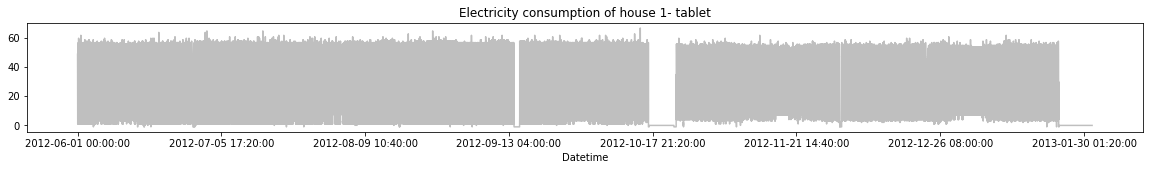

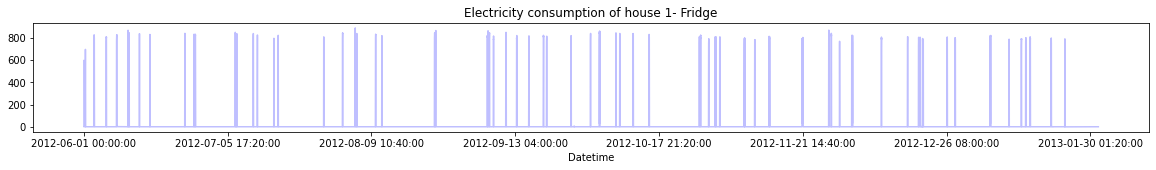

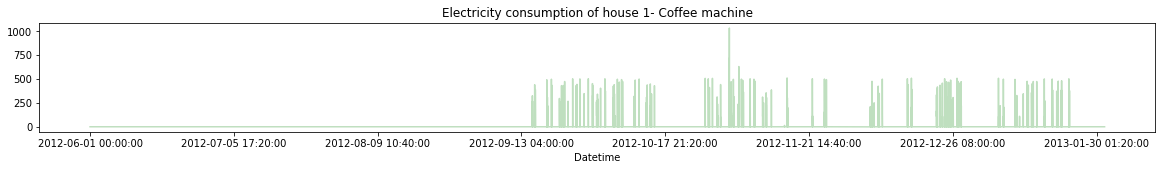

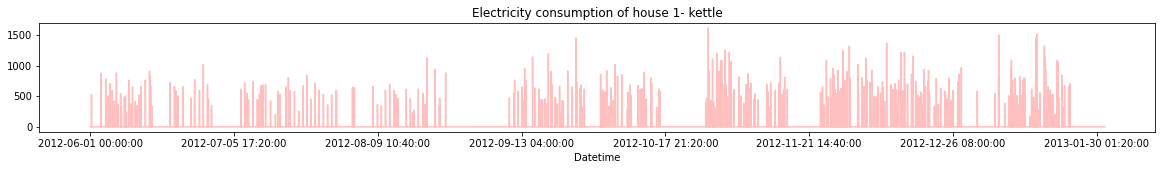

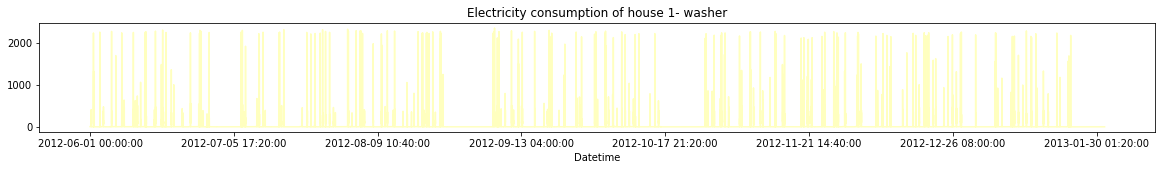

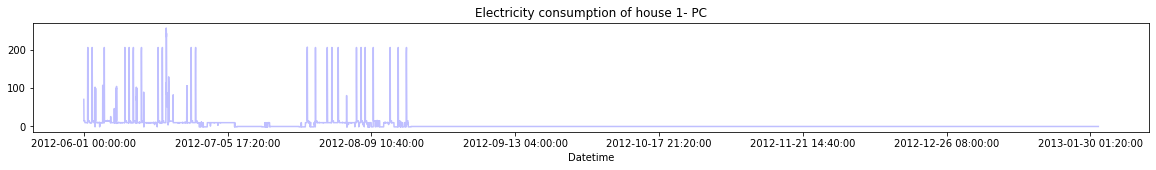

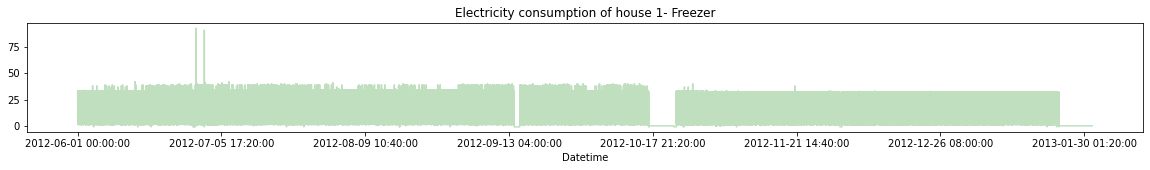

In [ ]:
df_plug=df_plug_gen[df_plug_gen.household==1]

#which household consume more energy
#which applicance is most used
#which what were the energy reading of each applicance 
df_plug.app_01.plot(figsize=(20,2),color='black',alpha=0.25,title='Electricity consumption of house 1- tablet');
plt.show();
df_plug.app_02.plot(figsize=(20,2),color='blue',alpha=0.25,title='Electricity consumption of house 1- Fridge');
plt.show();
df_plug.app_03.plot(figsize=(20,2),color='green',alpha=0.25,title='Electricity consumption of house 1- Coffee machine');
plt.show();
df_plug.app_04.plot(figsize=(20,2),color='red',alpha=0.25,title='Electricity consumption of house 1- kettle');
plt.show();
df_plug.app_05.plot(figsize=(20,2),color='yellow',alpha=0.25,title='Electricity consumption of house 1- washer');
plt.show();
df_plug.app_06.plot(figsize=(20,2),color='blue',alpha=0.25,title='Electricity consumption of house 1- PC');
plt.show();
df_plug.app_07.plot(figsize=(20,2),color='green',alpha=0.25,title='Electricity consumption of house 1- Freezer');
plt.show();

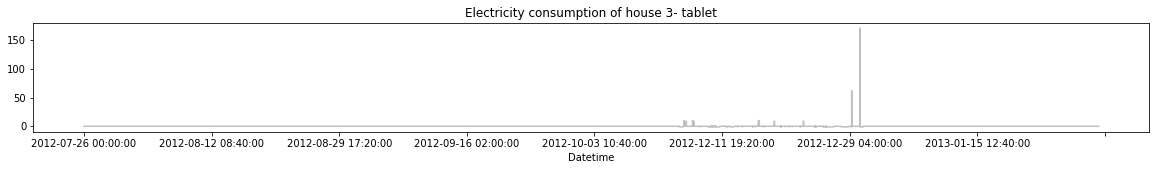

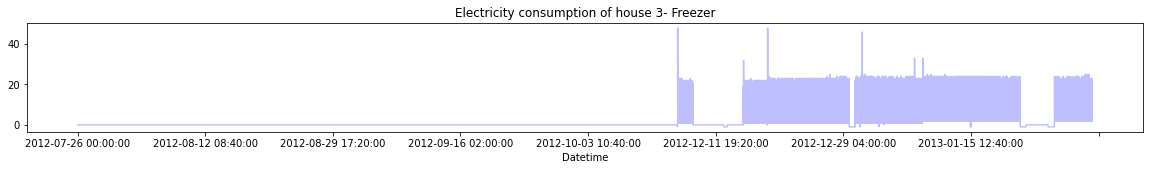

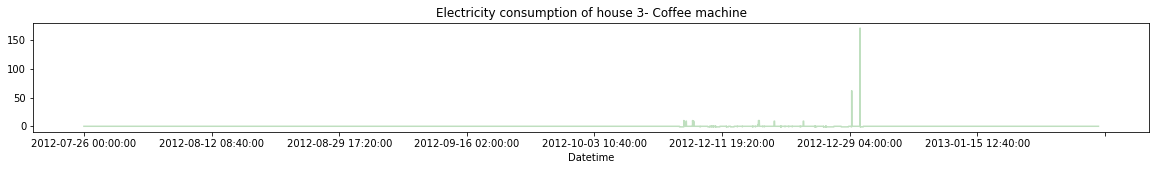

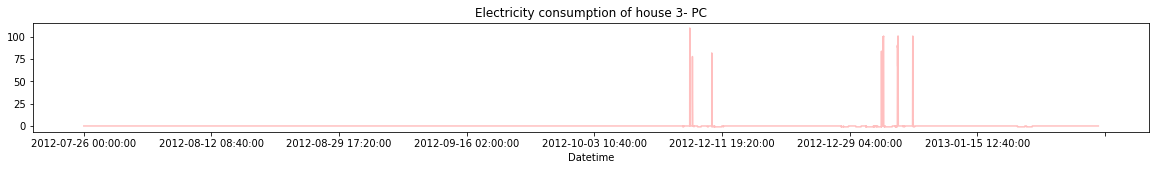

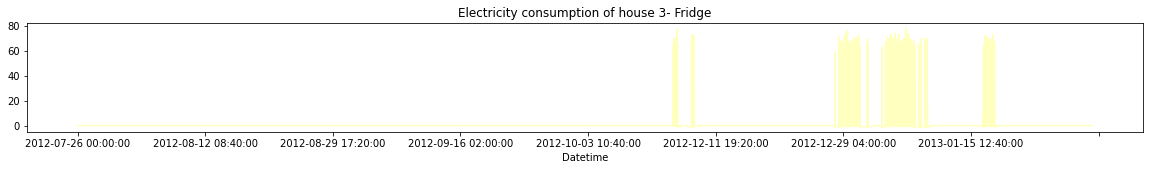

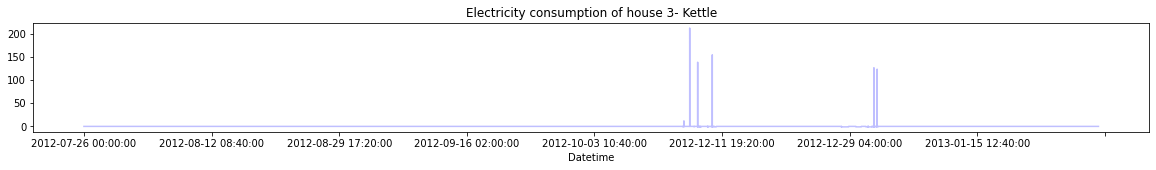

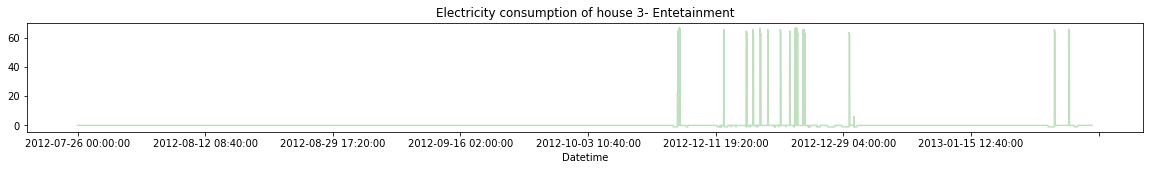

In [ ]:
df_plug=df_plug_gen[df_plug_gen.household==3]
#which household consume more energy
#which applicance is most used
#which what were the energy reading of each applicance 
df_plug.app_03.plot(figsize=(20,2),color='black',alpha=0.25,title='Electricity consumption of house 3- tablet');
plt.show();
df_plug.app_02.plot(figsize=(20,2),color='blue',alpha=0.25,title='Electricity consumption of house 3- Freezer');
plt.show();
df_plug.app_03.plot(figsize=(20,2),color='green',alpha=0.25,title='Electricity consumption of house 3- Coffee machine');
plt.show();
df_plug.app_04.plot(figsize=(20,2),color='red',alpha=0.25,title='Electricity consumption of house 3- PC');
plt.show();
df_plug.app_05.plot(figsize=(20,2),color='yellow',alpha=0.25,title='Electricity consumption of house 3- Fridge');
plt.show();
df_plug.app_06.plot(figsize=(20,2),color='blue',alpha=0.25,title='Electricity consumption of house 3- Kettle');
plt.show();
df_plug.app_07.plot(figsize=(20,2),color='green',alpha=0.25,title='Electricity consumption of house 3- Entetainment');
plt.show();

In [ ]:
df_plug=df_plug_gen


NameError: ignored

In [ ]:

h1=df_plug_gen[df_plug_gen.household==1][df_plug_gen.columns[3:10]].sum()
h2=df_plug_gen[df_plug_gen.household==2][df_plug_gen.columns[3:15]].sum()
h3=df_plug_gen[df_plug_gen.household==3][df_plug_gen.columns[3:11]].sum()
h4=df_plug_gen[df_plug_gen.household==4][df_plug_gen.columns[3:11]].sum()
h5=df_plug_gen[df_plug_gen.household==5][df_plug_gen.columns[3:11]].sum()
h6=df_plug_gen[df_plug_gen.household==6][df_plug_gen.columns[3:10]].sum()

<AxesSubplot:ylabel='None'>

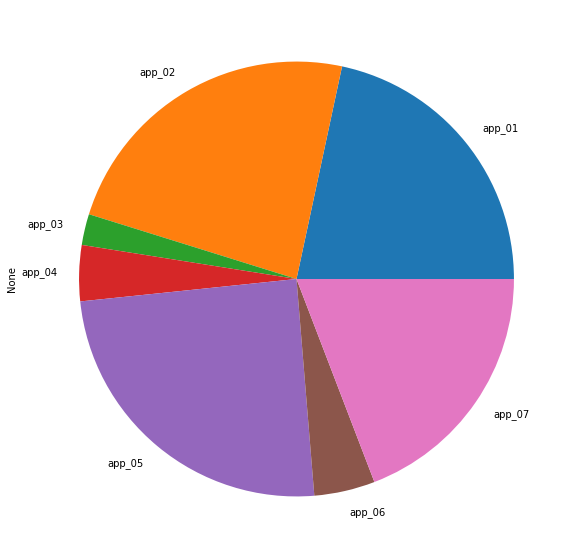

In [ ]:
h1.plot.pie( figsize=(10, 10))

<AxesSubplot:ylabel='None'>

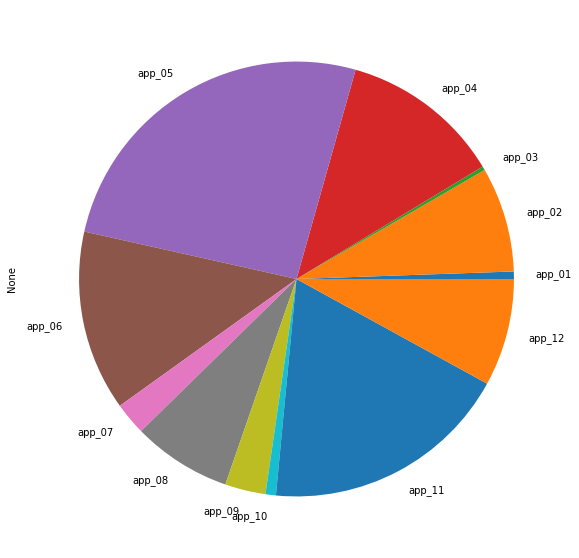

In [ ]:
h2.plot.pie( figsize=(10, 10))

<AxesSubplot:ylabel='None'>

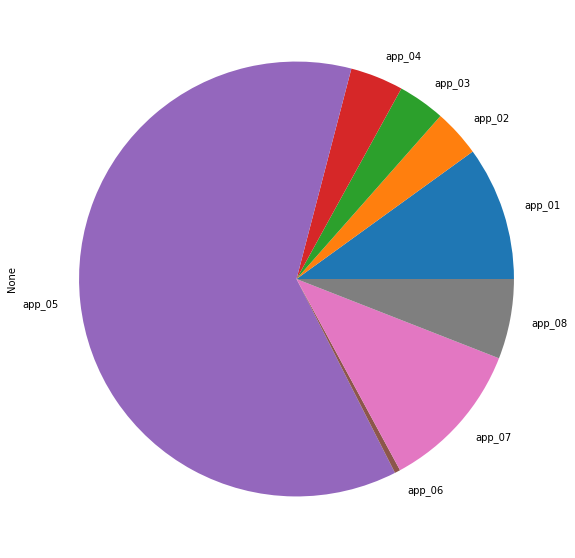

In [ ]:
h4.plot.pie( figsize=(10, 10))

<AxesSubplot:ylabel='None'>

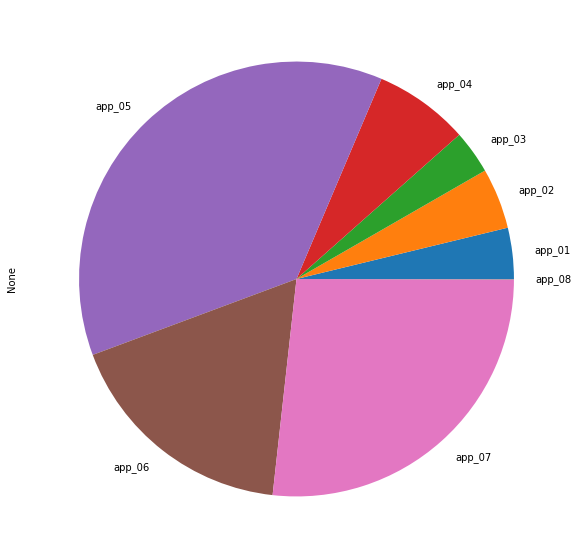

In [ ]:
h5.plot.pie( figsize=(10, 10))

<AxesSubplot:ylabel='None'>

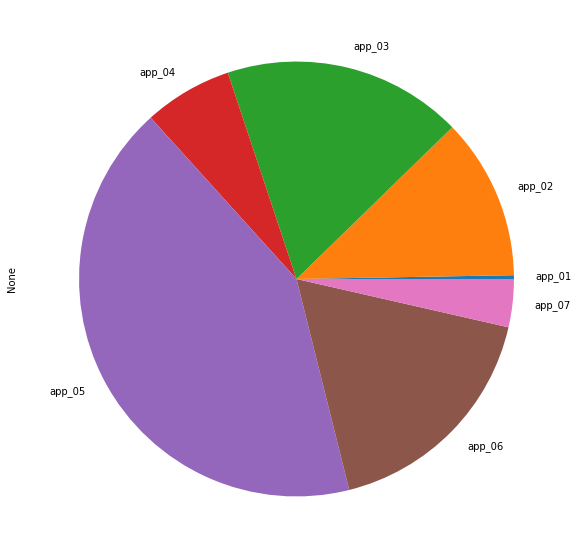

In [ ]:
h6.plot.pie( figsize=(10, 10))

In [ ]:
d

,p_total,p_phase1,p_phase2,p_phase3,i_neutral,i_phase1,i_phase2,i_phase3,v_phase1,v_phase2,...,app_03,app_04,app_05,app_06,app_07,app_08,app_09,app_10,app_11,app_12
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-06-01 00:00:00,797.0,112.0,65.0,620.0,2.0,1.0,0.0,3.0,237.0,236.0,...,0.0,0.0,5.0,71.0,22.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:05:00,208.0,111.0,60.0,37.0,1.0,1.0,0.0,0.0,236.0,235.0,...,0.0,0.0,5.0,59.0,33.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:10:00,202.0,100.0,60.0,41.0,1.0,1.0,0.0,0.0,236.0,235.0,...,0.0,0.0,5.0,50.0,32.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:15:00,185.0,91.0,54.0,40.0,1.0,1.0,0.0,0.0,237.0,235.0,...,0.0,0.0,5.0,42.0,32.0,0.0,0.0,0.0,0.0,0.0
2012-06-01 00:20:00,132.0,75.0,20.0,37.0,0.0,1.0,0.0,0.0,237.0,236.0,...,0.0,0.0,5.0,36.0,18.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-31 23:35:00,1258.0,4.0,25.0,1228.0,6.0,0.0,0.0,6.0,228.0,227.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-31 23:40:00,1257.0,4.0,25.0,1228.0,6.0,0.0,0.0,6.0,228.0,228.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-31 23:45:00,977.0,4.0,25.0,948.0,4.0,0.0,0.0,4.0,228.0,227.0,...,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df=pd.read_csv('drive/MyDrive/Capstone/Dataset/cleaned_data.csv')

In [ ]:
df.set_index('Datetime')

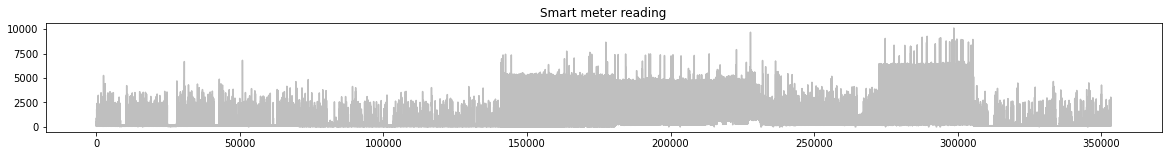

In [ ]:
df.p_total.plot(figsize=(20,2),color='black',alpha=0.25,title='Smart meter reading');
plt.show();

In [ ]:
df.Datetime

0         2012-06-01 00:00:00
1         2012-06-01 00:05:00
2         2012-06-01 00:10:00
3         2012-06-01 00:15:00
4         2012-06-01 00:20:00
                 ...         
353371    2013-01-31 23:35:00
353372    2013-01-31 23:40:00
353373    2013-01-31 23:45:00
353374    2013-01-31 23:50:00
353375    2013-01-31 23:55:00
Name: Datetime, Length: 353376, dtype: object